# All Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt



# All Constants

In [2]:
DATA_DIR = os.path.join('.', 'data')
SNP500_COMPANIES_FILE_PATH = os.path.join(DATA_DIR, 'sp500_companies.csv')
SNP500_INDEX_FILE_PATH     = os.path.join(DATA_DIR, 'sp500_index.csv')
SNP500_STOCKS_FILE_PATH    = os.path.join(DATA_DIR, 'sp500_stocks.csv')

# Lode Data in data frame

In [3]:
def load_sp500_data(sp500_companies, sp500_index, sp500_stocks):
    print("Loading all dataframe.")
    # Check file existence
    for file_path in [sp500_companies, sp500_index, sp500_stocks]:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
    return pd.read_csv(sp500_companies), pd.read_csv(sp500_index, parse_dates=["Date"]), pd.read_csv(sp500_stocks, parse_dates=["Date"])

df_sp500_companies, df_sp500_index, df_sp500_stocks = load_sp500_data(SNP500_COMPANIES_FILE_PATH, SNP500_INDEX_FILE_PATH, SNP500_STOCKS_FILE_PATH)




Loading all dataframe.


# Feature Engineering

In [4]:
def prepare_features(df):
    df = df.sort_values(['Symbol', 'Date']).copy()

    df['Lag_Close_1'] = df.groupby('Symbol')['Close'].shift(1)
    df['Lag_Return_1'] = df.groupby('Symbol')['Close'].pct_change(1)
    df['MA_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).mean())
    df['Std_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).std())
    df['Price_Diff'] = df['Close'] - df['Open']
    df['Volatility_Range'] = (df['High'] - df['Low']) / df['Close']
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
    df['Target_UpDown'] = (df['Next_Close'] > df['Close']).astype(int)

    df = df.dropna(subset=[
        'Lag_Close_1', 'Lag_Return_1', 'MA_Return_5', 'Std_Return_5',
        'Price_Diff', 'Volatility_Range', 'DayOfWeek', 'Target_UpDown'
    ])

    return df

def de_index(df):
    print("\n Adding Month and Date for Index data.")
    df['Month'] = df['Date'].astype(str).str[:7]
    df['Year'] = df['Date'].astype(str).str[:4]
    df['Daily Return'] = (df['S&P500'] / df['S&P500'].shift(1)) - 1
    return df


def remove_empty_or_nan_rows(df, name="DataFrame"):
    print(f"\n ******************** Cleaning: {name} ********************")
    
    rows_before = df.shape[0]
    print(f"Rows before cleanup: {rows_before}")

    # Replace blank strings with NaN and drop rows with any NaN
    df_cleaned = df.replace(r'^\s*$', np.nan, regex=True)
    df_cleaned = df_cleaned.dropna(how='any')
    df_cleaned = df_cleaned.reset_index(drop=True)

    rows_after = df_cleaned.shape[0]
    print(f"Rows after cleanup: {rows_after}")

    # Calculate and print % of rows dropped
    rows_dropped = rows_before - rows_after
    percent_dropped = (rows_dropped / rows_before) * 100 if rows_before > 0 else 0
    print(f"Percentage of rows removed: {percent_dropped:.2f}%")

    return df_cleaned

def combine_comp_and_stock(stock, compeny):
     print("\n Combining Stock and compeny data. \n")
     return  pd.merge(
        stock,
        compeny,
        on="Symbol",
        how="inner"
    )



In [5]:
df_sp500_index = de_index(df_sp500_index)


 Adding Month and Date for Index data.


# EDA

In [ ]:
def explore_columns_datatype(df, df_name="DataFrame"):
    print(f"\n *********************  Overview of {df_name} *********************")

    print("\nColumn Names:")
    print(list(df.columns))

    print("\nColumn Data Types:")
    print(df.dtypes)

    print("\nFirst 5 Rows:")
    print(df.head())


def explore_missing_values(df, df_name="DataFrame"):
    print(f"\n*********************   {df_name} *********************  \n")
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100

    missing_df = pd.DataFrame({
        "Missing Count": missing_counts,
        "Missing Percentage (%)": missing_percent.round(2)
    })

    print(missing_df[missing_df["Missing Count"] > 0].sort_values(by="Missing Count", ascending=False))
    
def plot_correlation_matrix(df, df_name="DataFrame"):
    corr = df.select_dtypes(include=['float64', 'int64']).corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f'Correlation Matrix for {df_name}')
    plt.tight_layout()
    plt.show()

def plot_numerical_distributions(df, df_name="DataFrame"):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True, bins=50)
        plt.title(f'Distribution of {col} in {df_name}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

def plot_categorical_counts(df, df_name="DataFrame"):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        value_counts = df[col].value_counts().head(20)
        if not value_counts.empty:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Top Categories of {col} in {df_name}')
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

def print_column_unique_value(df, columnName):
    print(f"\n Unique Value for {columnName}",df[columnName].unique())


def plot_exchange_distribution_bar(df):
    """
    Plots a bar chart showing count and percentage of stocks per exchange.
    """
    exchange_counts = df['Exchange'].value_counts()
    total = exchange_counts.sum()
    percentages = (exchange_counts / total) * 100

    plt.figure(figsize=(8, 6))
    bars = plt.bar(exchange_counts.index, exchange_counts.values, color=plt.cm.Set2.colors)

    for bar, percentage, count in zip(bars, percentages, exchange_counts.values):
        height = bar.get_height()
        label = f'{percentage:.1f}%\n({count})'
        plt.text(bar.get_x() + bar.get_width() / 2, height, label,
                 ha='center', va='bottom', fontsize=10)

    plt.title('Stock Count and Percentage by Exchange', fontsize=14, weight='bold')
    plt.xlabel('Exchange')
    plt.ylabel('Number of Stocks')
    plt.tight_layout()
    plt.show()



def plot_category_pie_chart(df, column_name, title=None):
    """
    Plots a pie chart with counts and percentages for a given categorical column.
    """
    category_counts = df[column_name].value_counts()
    labels = [f"{cat} ({count})" for cat, count in zip(category_counts.index, category_counts.values)]

    fig, ax = plt.subplots(figsize=(10, 8))
    wedges, texts, autotexts = ax.pie(
        category_counts,
        labels=None,
        autopct=lambda pct: f"{pct:.1f}%",  # Show only % inside
        startangle=90,
        counterclock=False,
        pctdistance=0.85,
        colors=plt.cm.tab20.colors
    )

    ax.legend(
        wedges,
        labels,
        title=f'{column_name} (count)',
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=9
    )

    ax.set_title(title if title else f'Distribution of {column_name}', pad=20, fontsize=14, weight='bold')
    ax.axis('equal')
    plt.tight_layout()
    plt.show()


def apply_log1p_transform(df, columns, inplace=True):
    if not inplace:
        df = df.copy()

    for col in columns:
        new_col = f"log1p_{col}"
        df[new_col] = np.log1p(df[col])
    
    return df

def visualize_log1p_transformation(df, column, log_column, title_prefix=""):
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(df[column].dropna(), label=f"Original {column}", fill=True, color='skyblue')
    sns.kdeplot(df[log_column].dropna(), label=f"Log1p Transformed {column}", fill=True, color='orange')

    plt.title(f"{title_prefix} Distribution: {column} vs {log_column}", fontsize=14, weight='bold')
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_sp500_performance(sp_500_index, num_years=None):
    if 'Year' not in sp_500_index.columns:
        sp_500_index['Year'] = sp_500_index['Date'].dt.year

    # Filter data based on year
    if num_years:
        latest_year = sp_500_index['Year'].max()
        filtered_df = sp_500_index[sp_500_index['Year'] >= (latest_year - num_years)]
    else:
        filtered_df = sp_500_index

    # Plot
    ax = filtered_df[['Date', 'S&P500']].set_index('Date').plot(figsize=(10, 8))
    plt.title("S&P 500 Index Performance", weight='bold', fontsize=15)
    ax.set_xlabel("Date", weight='bold', fontsize=13)
    ax.set_ylabel("Daily S&P 500 Index Price", weight='bold', fontsize=13)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def plot_stock_performance_by_symbol(df, symbols, column='Close'):
    if 'Date' not in df.columns or 'Symbol' not in df.columns or column not in df.columns:
        raise ValueError(f"DataFrame must contain 'Date', 'Symbol', and '{column}' columns.")
    
    plt.figure(figsize=(14, 8))
    has_data = False

    for symbol in symbols:
        df_symbol = df[df['Symbol'] == symbol].copy()
        if df_symbol.empty:
            print(f"No data for symbol: {symbol}")
            continue

        df_symbol = df_symbol.sort_values('Date')
        plt.plot(df_symbol['Date'], df_symbol[column], label=symbol)
        has_data = True

    if has_data:
        plt.title(f'{column} Price Performance for Selected Stocks', fontsize=16, weight='bold')
        plt.xlabel('Date', fontsize=14, weight='bold')
        plt.ylabel(f'{column} Price', fontsize=14, weight='bold')
        plt.legend(title='Stock Symbol', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid data found for any of the provided symbols.")


def plot_index_vs_stock(df_stock, df_index, symbol):
    df_stock = df_stock[df_stock['Symbol'] == symbol].copy()
    df = pd.merge(df_stock, df_index, on='Date', how='inner')

    df['Normalized_Close'] = df['Close'] / df['Close'].iloc[0]
    df['Normalized_S&P500'] = df['S&P500'] / df['S&P500'].iloc[0]

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Normalized_Close'], label=f'{symbol} Stock')
    plt.plot(df['Date'], df['Normalized_S&P500'], label='S&P 500 Index')
    plt.title(f'Normalized {symbol} vs S&P 500 Index')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def plot_return_comparison(df_stock, df_index, symbol):
    df_symbol = df_stock[df_stock['Symbol'] == symbol].copy()
    df_symbol = df_symbol[['Date', 'Close']].dropna()
    df_symbol['Date'] = pd.to_datetime(df_symbol['Date'])
    df_symbol = df_symbol.sort_values('Date')
    df_symbol['Return'] = df_symbol['Close'].pct_change()

    df_index = df_index.copy()
    df_index = df_index[['Date', 'S&P500']].dropna()
    df_index['Date'] = pd.to_datetime(df_index['Date'])
    df_index = df_index.sort_values('Date')
    df_index['Return'] = df_index['S&P500'].pct_change()

    # Merge on date
    df_merged = pd.merge(df_symbol, df_index, on='Date', how='inner', suffixes=('_stock', '_index'))

    plt.figure(figsize=(12, 6))
    plt.plot(df_merged['Date'], df_merged['Return_stock'], label=f'{symbol} Return', color='blue')
    plt.plot(df_merged['Date'], df_merged['Return_index'], label='S&P 500 Return', color='orange')
    plt.title(f'Daily Returns: {symbol} vs S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


   

## EDA on Raw data

In [7]:
explore_columns_datatype(df_sp500_companies, "S&P500 Companies")
explore_columns_datatype(df_sp500_index, "S&P500 Index")
explore_columns_datatype(df_sp500_stocks, "S&P500 Stocks")

explore_missing_values(df_sp500_companies, "S&P500 Companies")
explore_missing_values(df_sp500_index, "S&P500 Index")
explore_missing_values(df_sp500_stocks, "S&P500 Stocks")




 *********************  Overview of S&P500 Companies *********************

Column Names:
['Exchange', 'Symbol', 'Shortname', 'Longname', 'Sector', 'Industry', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight']

Column Data Types:
Exchange                object
Symbol                  object
Shortname               object
Longname                object
Sector                  object
Industry                object
Currentprice           float64
Marketcap                int64
Ebitda                 float64
Revenuegrowth          float64
City                    object
State                   object
Country                 object
Fulltimeemployees      float64
Longbusinesssummary     object
Weight                 float64
dtype: object

First 5 Rows:
  Exchange Symbol              Shortname               Longname  \
0      NMS   AAPL             Apple Inc.             Apple Inc.   
1      NMS   NVDA     

In [8]:
df_sp500_companies = remove_empty_or_nan_rows(df_sp500_companies, "S&P500 Companies")
df_sp500_index = remove_empty_or_nan_rows(df_sp500_index, "S&P500 Index")
df_sp500_stocks = remove_empty_or_nan_rows(df_sp500_stocks, "S&P500 Stocks")
df_companies_and_stock = combine_comp_and_stock(df_sp500_stocks, df_sp500_companies)
row_count = df_companies_and_stock.shape[0]
print("df_companies_and_stock Row count:", row_count)
explore_columns_datatype(df_companies_and_stock, df_name="df_companies_and_stock DataFrame")


 ******************** Cleaning: S&P500 Companies ********************
Rows before cleanup: 502
Rows after cleanup: 443
Percentage of rows removed: 11.75%

 ******************** Cleaning: S&P500 Index ********************
Rows before cleanup: 2517
Rows after cleanup: 2516
Percentage of rows removed: 0.04%

 ******************** Cleaning: S&P500 Stocks ********************
Rows before cleanup: 1891536
Rows after cleanup: 617831
Percentage of rows removed: 67.34%

 Combining Stock and compeny data. 

df_companies_and_stock Row count: 540645

 *********************  Overview of df_companies_and_stock DataFrame *********************

Column Names:
['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Exchange', 'Shortname', 'Longname', 'Sector', 'Industry', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight']

Column Data Types:
Date                   datetime64[ns]
Symbol             

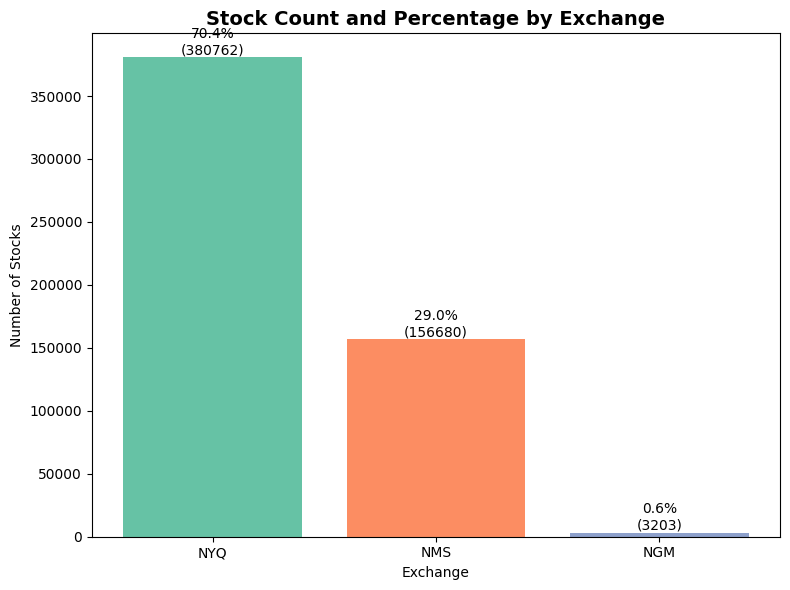

In [9]:
plot_exchange_distribution_bar(df_companies_and_stock)


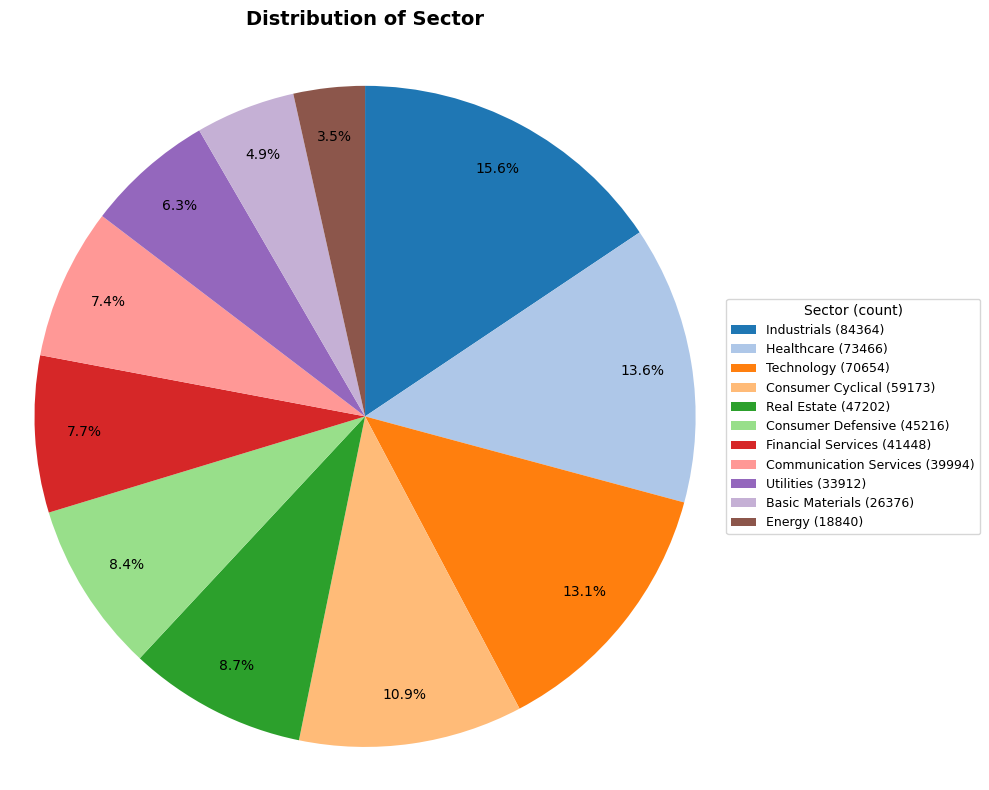

In [10]:
plot_category_pie_chart(df_companies_and_stock, 'Sector')


C:\Users\atul1\AppData\Local\Temp\ipykernel_29012\4121130220.py:116: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


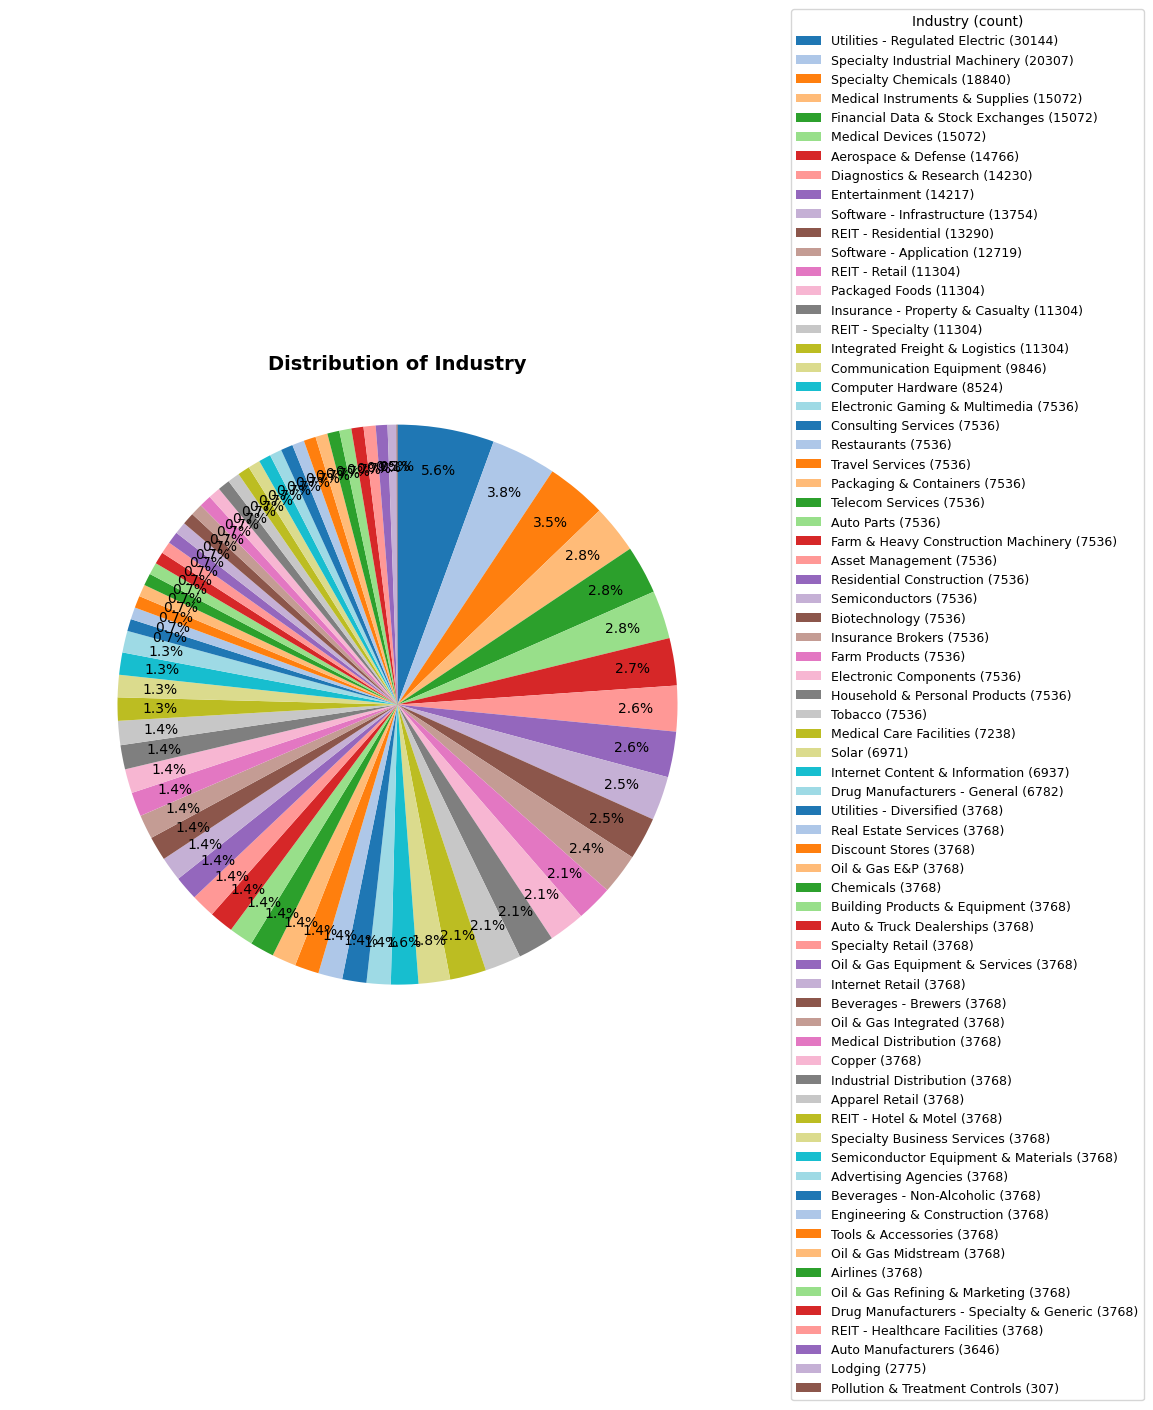

In [11]:
plot_category_pie_chart(df_companies_and_stock, 'Industry') #To look better we can plot just for top 20 or 30


c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


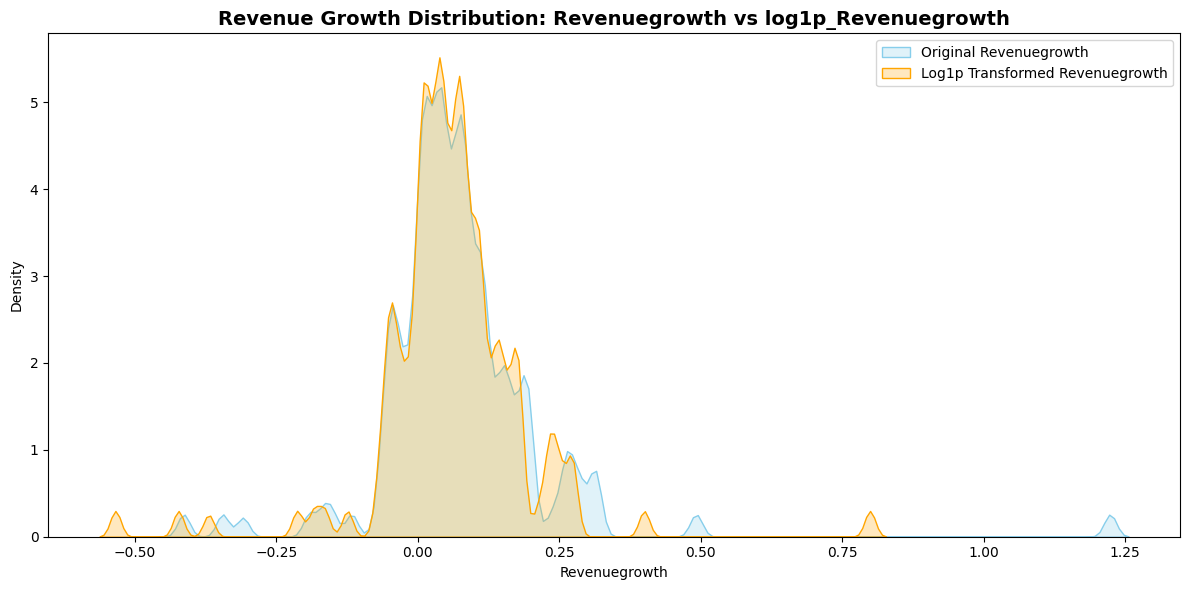

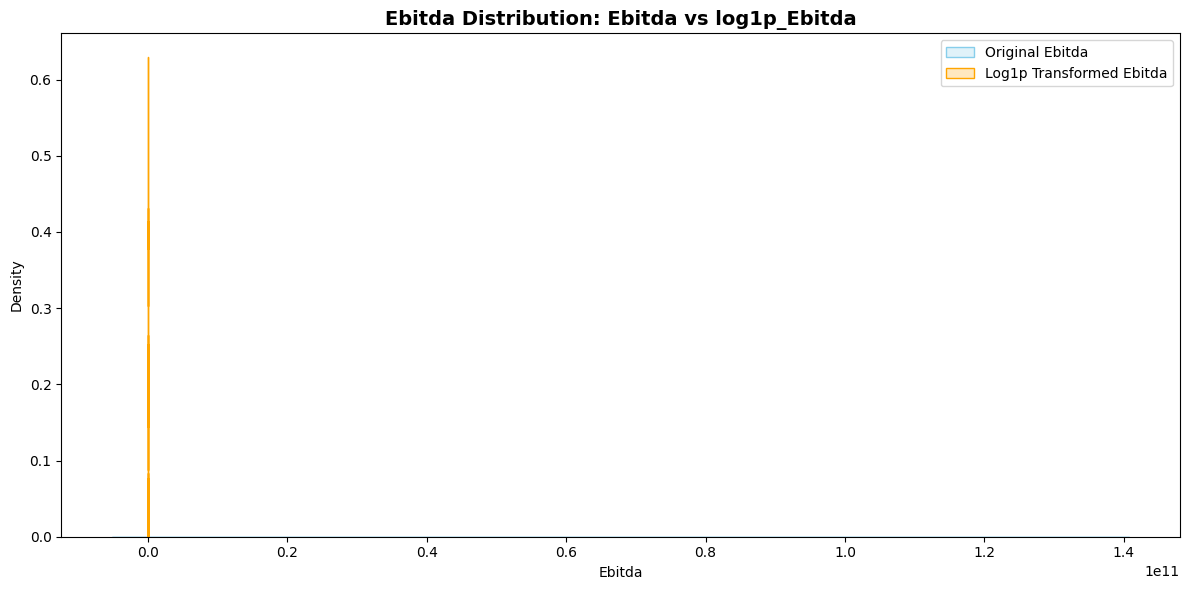

In [12]:


df_companies_and_stock = apply_log1p_transform(df_companies_and_stock, ['Revenuegrowth', 'Ebitda'])
visualize_log1p_transformation(df_companies_and_stock, 'Revenuegrowth', 'log1p_Revenuegrowth', title_prefix="Revenue Growth")
visualize_log1p_transformation(df_companies_and_stock, 'Ebitda', 'log1p_Ebitda', title_prefix="Ebitda")


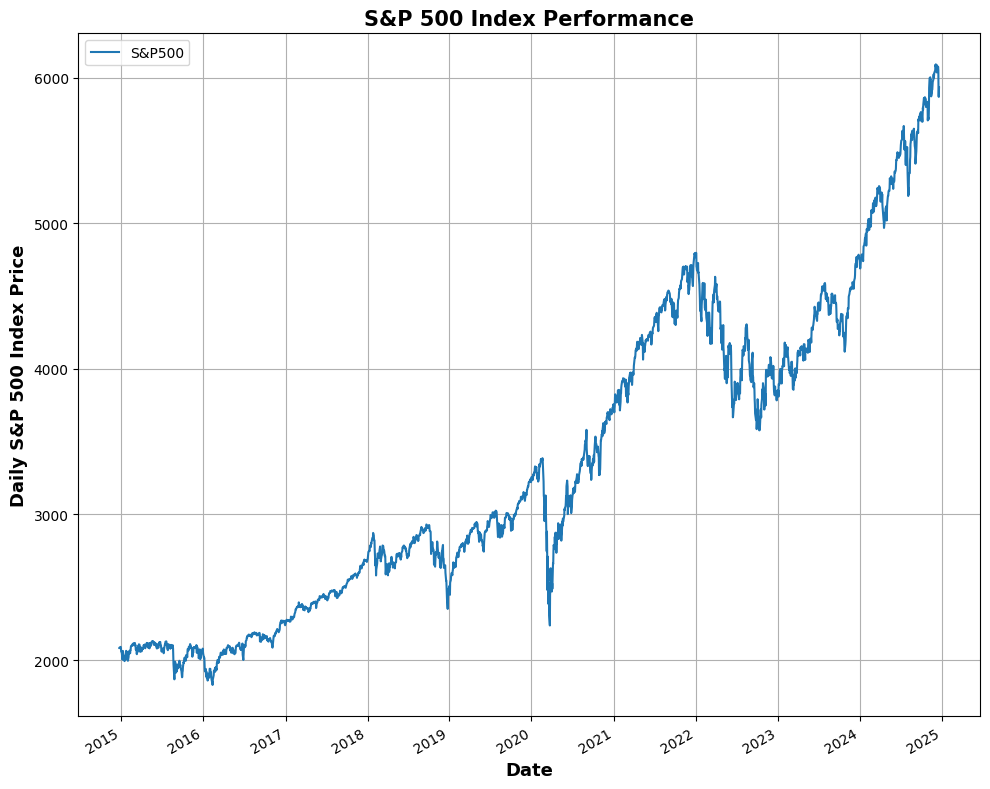

In [13]:
plot_sp500_performance(df_sp500_index)

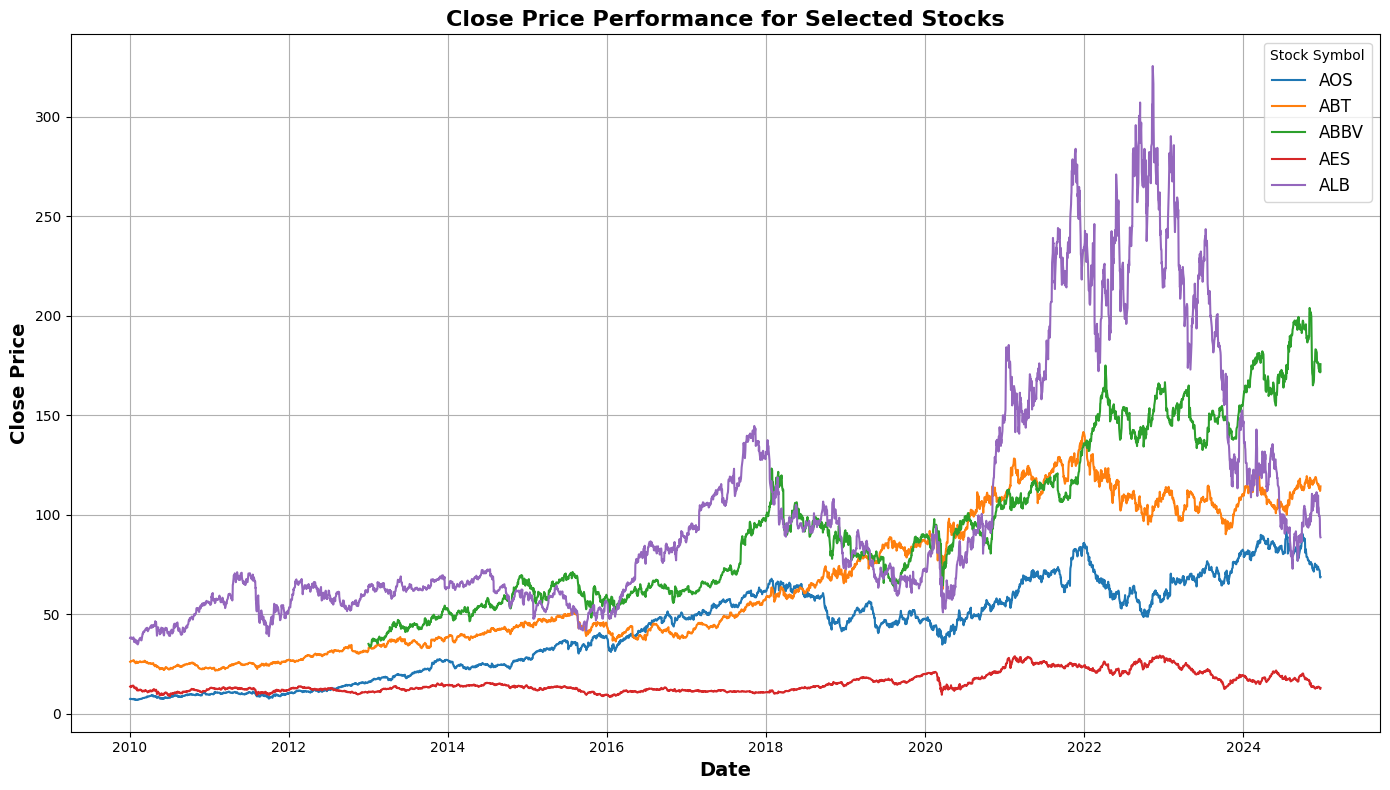

In [14]:
#plot_stock_performance_by_symbol(df_companies_and_stock, ['AAPL', 'MSFT', 'GOOGL'])
plot_stock_performance_by_symbol(df_companies_and_stock, df_companies_and_stock['Symbol'].unique()[:5])


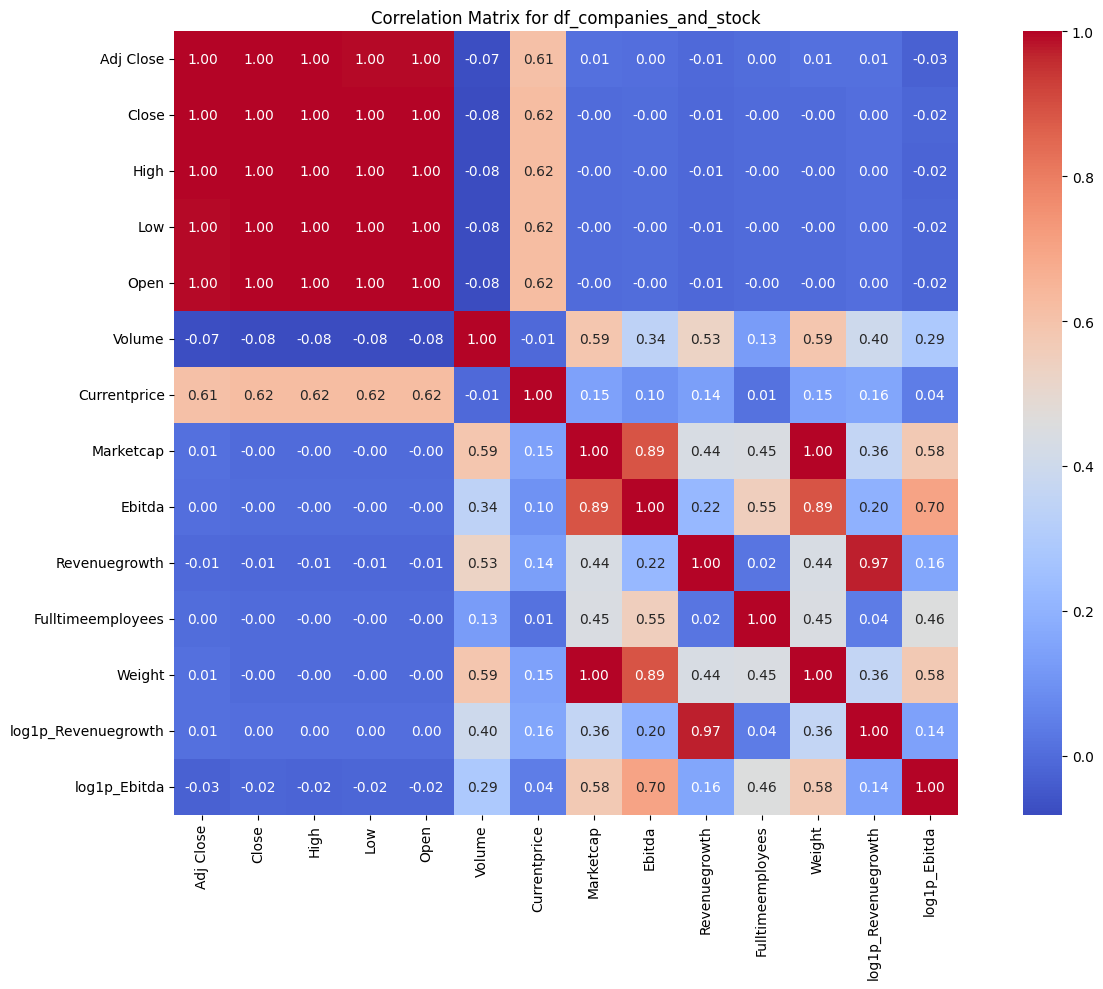

In [15]:
plot_correlation_matrix(df_companies_and_stock, "df_companies_and_stock")


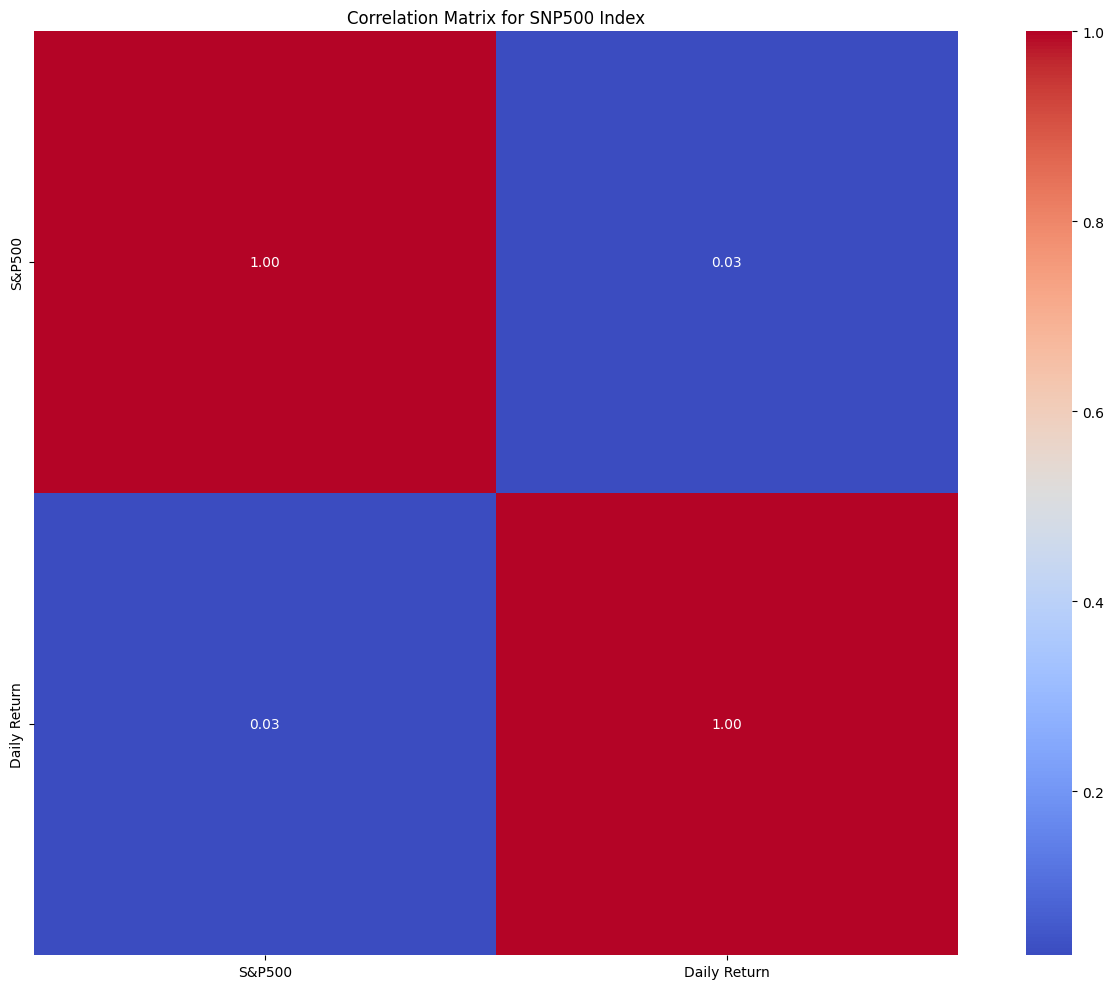

In [16]:
plot_correlation_matrix(df_sp500_index, "SNP500 Index")


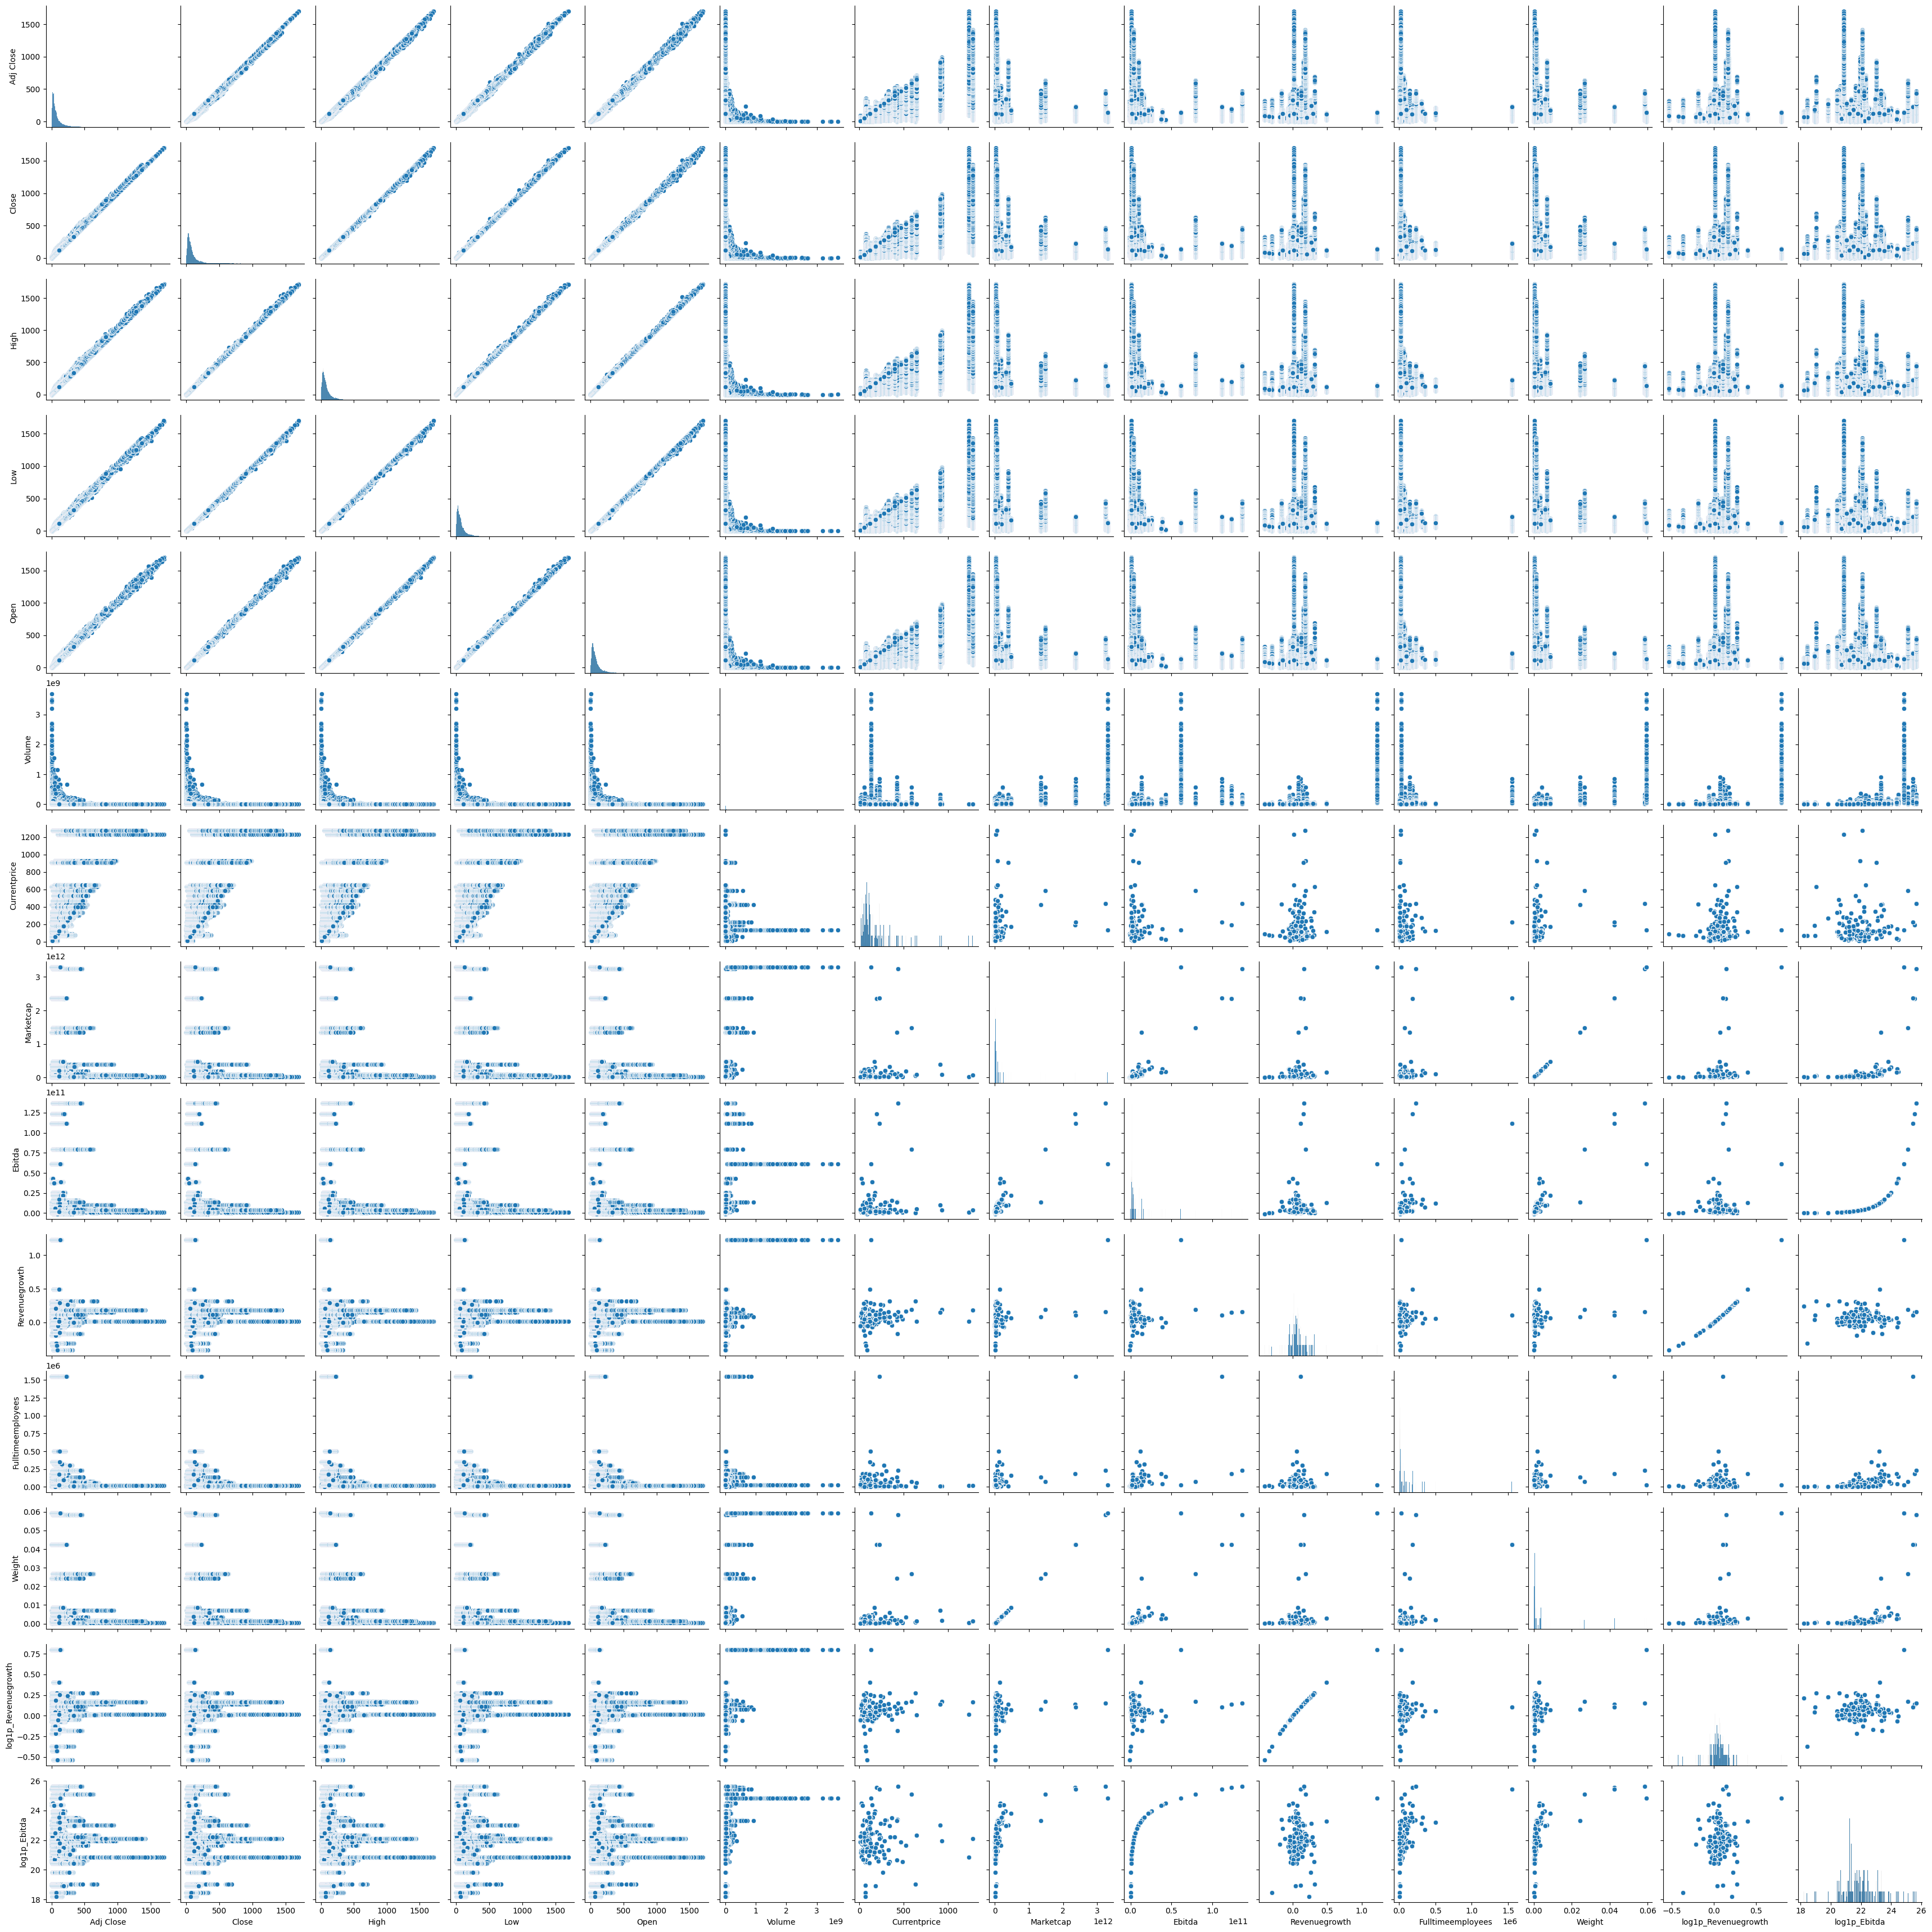

In [20]:
sns.pairplot(df_companies_and_stock) 
plt.show()

In [18]:
#p = sns.PairGrid(df_companies_and_stock) # Calling pointplot for the entire dataframe
#p.map(sns.stripplot, jitter=True, size=3) # Adding jitter by specifying striplot

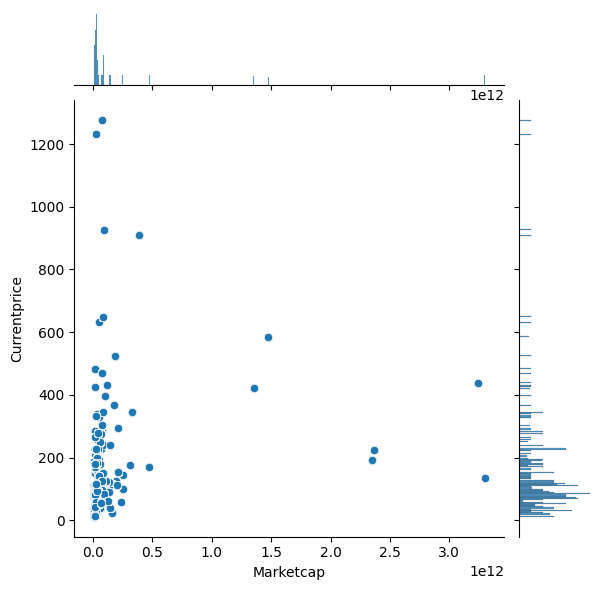

In [19]:
sns.jointplot(data=df_companies_and_stock, x='Marketcap', y='Currentprice', kind='scatter')

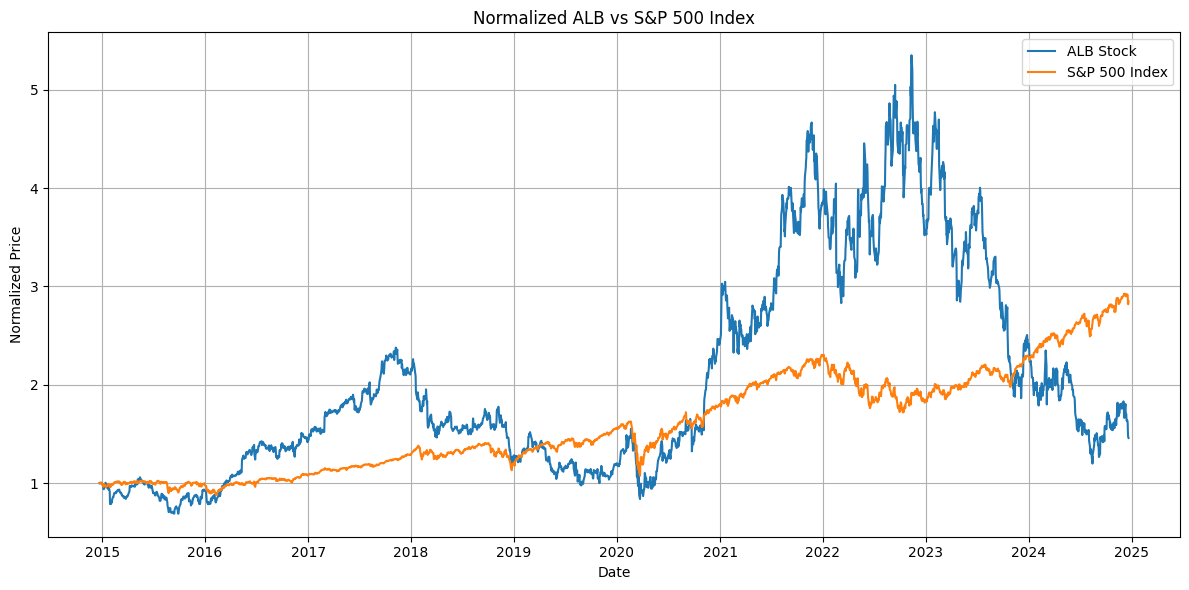

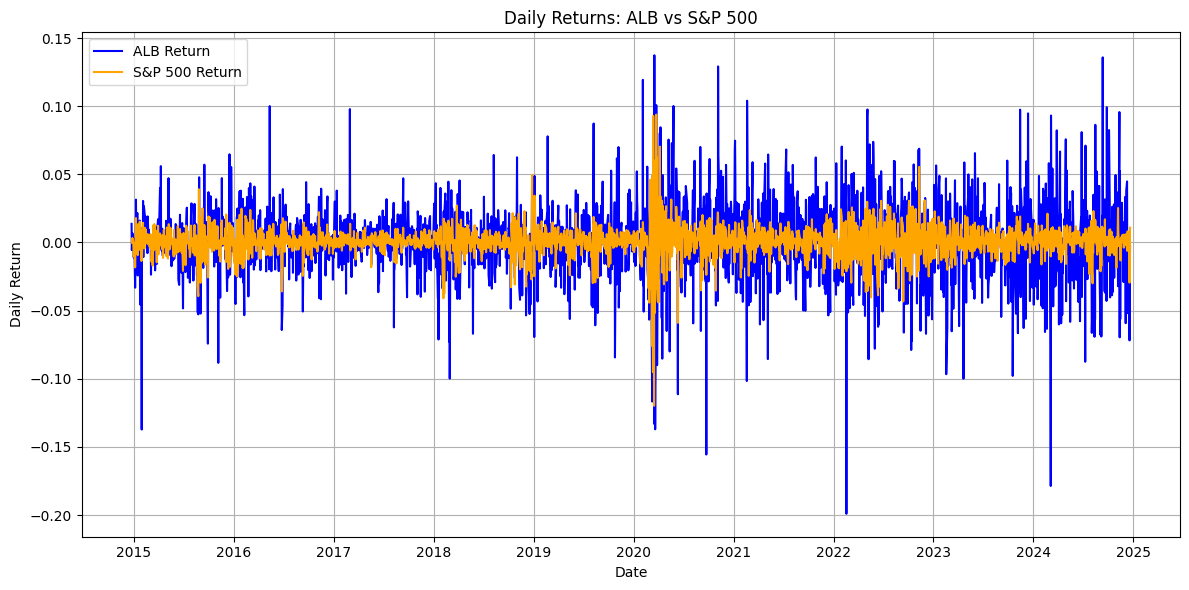

In [25]:
plot_index_vs_stock(df_companies_and_stock, df_sp500_index, 'ALB')
plot_return_comparison(df_companies_and_stock, df_sp500_index, 'ALB')
